In [10]:
# 필요한 라이브러리 가져오기
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import optuna

# Set the random state for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 데이터 로드 및 전처리
data_path = 'C:\\Users\\user\\Desktop\\PV\\실험\\전처리_v3\\Sejong_v3.csv'  
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])

# Normalize features except 'Date' and 'Solar_Power'
features = data.columns.drop(['Date', 'PVGeneration'])
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# 데이터 분할
train_data = data[data['Date'] < pd.to_datetime('2019-01-01 08:00:00')]
test_data = data[(data['Date'] >= pd.to_datetime('2019-01-01 08:00:00')) & (data['Date'] <= pd.to_datetime('2019-12-31 18:00:00'))]
val_size = int(0.1 * len(train_data))
train_df, val_df = torch.utils.data.random_split(train_data, [len(train_data) - val_size, val_size])

device = torch.device("cuda")

# 하이퍼파라미터 설정
hyperparameters = {
    'num_layers': 2,
    'hidden_size': 50,
    'output_size': 1,  # 출력 크기는 예측 시간 단계 수로 변경될 예정
    'num_epochs': 100,
    'window_size': 36,
    'forecast_horizon': 11,  # 추가: 다음 11시간을 예측
    'batch_size': 64,
    'learning_rate': 0.001,
    'input_size': len(features)
}

# TimeSeriesDataset 클래스
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size, forecast_horizon):
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.features = df.columns.drop(['Date', 'PVGeneration'])

    def __len__(self):
        return len(self.df) - self.window_size - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.df.loc[idx:idx + self.window_size - 1, self.features].values
        y = self.df.loc[idx + self.window_size:idx + self.window_size + self.forecast_horizon - 1, 'PVGeneration'].values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# Train, Validation 데이터셋 생성 시 Subset 객체 대신 실제 데이터 프레임 사용
train_data_subset = train_data.iloc[train_df.indices].reset_index(drop=True)
val_data_subset = train_data.iloc[val_df.indices].reset_index(drop=True)

# Train, Validation, Test 데이터셋 생성
train_dataset = TimeSeriesDataset(train_data_subset, hyperparameters['window_size'], hyperparameters['forecast_horizon'])
val_dataset = TimeSeriesDataset(val_data_subset, hyperparameters['window_size'], hyperparameters['forecast_horizon'])
test_dataset = TimeSeriesDataset(test_data, hyperparameters['window_size'], hyperparameters['forecast_horizon'])

# 데이터 로더 정의
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, forecast_horizon, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        if num_layers > 1:
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        else:
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, forecast_horizon)  # 출력 크기 조정

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 손실 함수 및 평가 지표 정의
def nrmse(predictions, targets):
    rmse = sqrt(mean_squared_error(predictions, targets))
    return rmse / np.mean(targets)

def nmae(predictions, targets):
    mae_value = mean_absolute_error(predictions, targets)
    return mae_value / np.mean(targets)

def r2(predictions, targets):
    return r2_score(targets, predictions)

# 모델 평가 함수
def evaluate_model(model, test_loader, device, prediction_steps=11):
    model.eval()
    metrics_per_step = []

    with torch.no_grad():
        for step in range(prediction_steps):
            all_targets = []
            all_outputs = []
            for data, target in test_loader:
                data = data.to(device)
                output = model(data)  # output shape is [batch_size, forecast_horizon]
                output = output.view(-1, prediction_steps)  # reshaping to separate predictions
                target = target.view(-1)  # flatten target to match output's shape
                if step < target.size(0):  # check if there's enough data for this step
                    all_outputs.append(output[:, step].cpu().numpy())  # select prediction for the current step
                    all_targets.append(target.cpu().numpy())

            all_outputs = np.concatenate(all_outputs)
            all_targets = np.concatenate(all_targets)

            # Now ensure all_outputs and all_targets have the same length
            min_length = min(len(all_outputs), len(all_targets))
            all_outputs = all_outputs[:min_length]
            all_targets = all_targets[:min_length]

            avg_rmse = sqrt(mean_squared_error(all_targets, all_outputs))
            avg_nrmse = nrmse(np.array(all_outputs), np.array(all_targets))
            avg_nmae = nmae(np.array(all_outputs), np.array(all_targets))
            avg_r2 = r2(np.array(all_outputs), np.array(all_targets))

            metrics_per_step.append((avg_rmse, avg_nrmse, avg_nmae, avg_r2))
            print(f"Step {step+1}: RMSE: {avg_rmse}, NRMSE: {avg_nrmse}, NMAE: {avg_nmae}, R^2: {avg_r2}")

    # Calculate and return average metrics across all steps
    avg_rmse = np.mean([m[0] for m in metrics_per_step])
    avg_nrmse = np.mean([m[1] for m in metrics_per_step])
    avg_nmae = np.mean([m[2] for m in metrics_per_step])
    avg_r2 = np.mean([m[3] for m in metrics_per_step])
    print(f"Average: RMSE: {avg_rmse}, NRMSE: {avg_nrmse}, NMAE: {avg_nmae}, R^2: {avg_r2}")

    return avg_rmse, avg_nrmse, avg_nmae, avg_r2


# 손실 함수
mse_loss = nn.MSELoss()

# Optuna를 사용한 하이퍼파라미터 최적화
def objective(trial):
    # 기존 매개변수 정의 부분은 그대로 유지
    input_size = hyperparameters['input_size']
    hidden_size = trial.suggest_int('hidden_size', 16, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 32, 256)

    # LSTMModel 인스턴스 생성 시 forecast_horizon 매개변수 추가
    model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, forecast_horizon=hyperparameters['forecast_horizon'], dropout_rate=0.3).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(hyperparameters['num_epochs']):
        model.train()
        for seqs, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(seqs).squeeze()  # .squeeze() 추가하여 차원 축소
            loss = mse_loss(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seqs, labels in val_loader:
                seqs, labels = seqs.to(device), labels.to(device)
                outputs = model(seqs).squeeze()  # .squeeze() 추가하여 차원 축소
                loss = mse_loss(outputs, labels)
                val_loss += loss.item()

    return val_loss / len(val_loader)


# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 100)
best_params = study.best_trial.params

# 최적의 하이퍼파라미터를 사용하여 모델 생성
best_model = LSTMModel(
    input_size=hyperparameters['input_size'],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    forecast_horizon=hyperparameters['forecast_horizon'],  # 이 부분이 추가됨
    dropout_rate=0.3  # 선택적으로 dropout_rate도 조정할 수 있음
).to(device)

# 최적의 하이퍼파라미터를 사용하여 옵티마이저 및 데이터 로더 설정
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)



# 모델 학습
for epoch in range(hyperparameters['num_epochs']):  # num_epochs를 사용하여 반복
    best_model.train()  # 모델을 학습 모드로 설정
    total_loss = 0
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(seqs).squeeze()  # 차원 축소
        loss = mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Test DataLoader 준비 - 수정된 부분
test_dataset = TimeSeriesDataset(test_data, hyperparameters['window_size'], hyperparameters['forecast_horizon'])  # forecast_horizon 추가
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

# 모델 평가
avg_rmse, avg_nrmse, avg_nmae, avg_r2 = evaluate_model(best_model, test_loader, device)



[I 2024-03-11 20:43:08,160] A new study created in memory with name: no-name-4d963b1e-92a1-414a-9570-6838a8142d90
C:\Users\user\AppData\Local\Temp\ipykernel_17832\3377013401.py:162: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2024-03-11 20:47:28,107] Trial 0 finished with value: 0.07684883172623813 and parameters: {'hidden_size': 114, 'num_layers': 3, 'learning_rate': 0.03553718958888369, 'batch_size': 50}. Best is trial 0 with value: 0.07684883172623813.
c:\Users\user\anaconda3\envs\min_hs_lstm3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 11])) that is different to the input size (torch.Size([11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 1, Loss: 0.20181960517015213
Epoch 2, Loss: 0.19416540631881127
Epoch 3, Loss: 0.18699057400226593
Epoch 4, Loss: 0.1795967141023049
Epoch 5, Loss: 0.17149326969415712
Epoch 6, Loss: 0.16278333618090704
Epoch 7, Loss: 0.15315406024456024
Epoch 8, Loss: 0.14198276476982313
Epoch 9, Loss: 0.1296355495086083
Epoch 10, Loss: 0.11589257610149872
Epoch 11, Loss: 0.10309262688343342
Epoch 12, Loss: 0.0938397710904097
Epoch 13, Loss: 0.0890816004994588
Epoch 14, Loss: 0.08608797154365441
Epoch 15, Loss: 0.08396337353266202
Epoch 16, Loss: 0.08252017620282295
Epoch 17, Loss: 0.08159359105122395
Epoch 18, Loss: 0.08094868235863172
Epoch 19, Loss: 0.08027928398969846
Epoch 20, Loss: 0.07994795877199906
Epoch 21, Loss: 0.07973526666561763
Epoch 22, Loss: 0.07966513301317509
Epoch 23, Loss: 0.07950340956449509
Epoch 24, Loss: 0.07939487351821019
Epoch 25, Loss: 0.07936911552380292
Epoch 26, Loss: 0.07929871116693203
Epoch 27, Loss: 0.07918640894767566
Epoch 28, Loss: 0.07931830294621296
Epoch

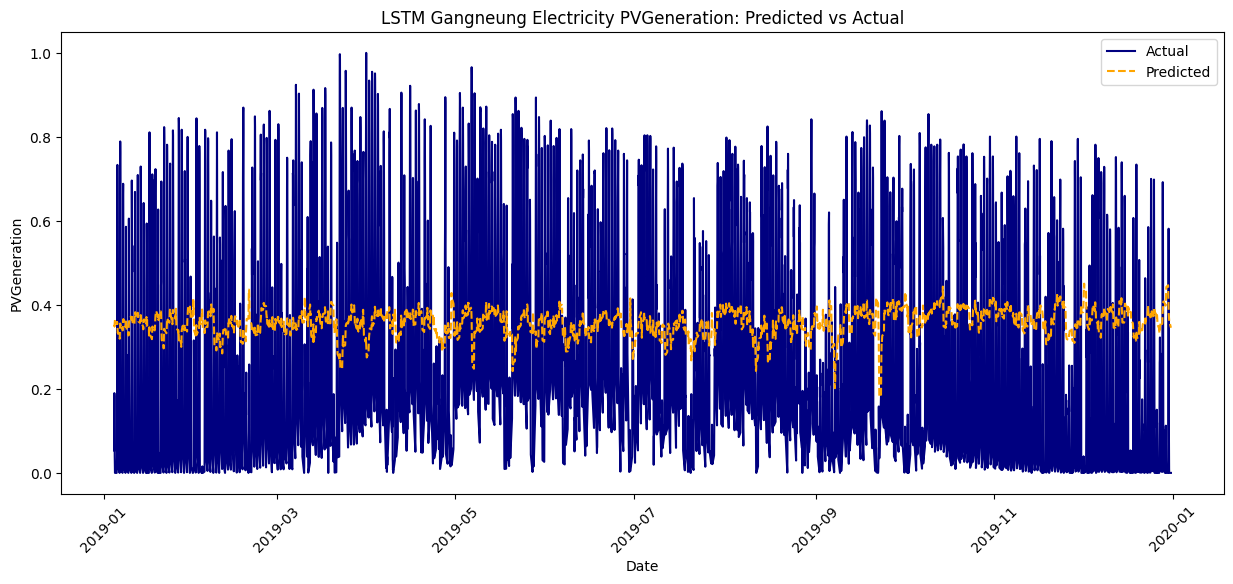

In [9]:
import matplotlib.pyplot as plt
import torch

# 모델을 평가 모드로 설정
best_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = best_model(data)
        # output을 1차원 배열로 변환하여 predictions 리스트에 추가
        # 각 예측 시퀀스에 대한 첫 번째 예측값만 사용하되, 항상 1차원 배열로 처리
        pred = output[:, 0].detach().cpu().numpy()  # 1차원 배열을 유지
        # pred가 스칼라 값이면 리스트로 변환하여 extend
        predictions.extend(pred.flatten() if pred.ndim > 0 else [pred.item()])
        # 실제값 처리 시에도 동일한 방식 적용
        act = target[:, 0].cpu().numpy()
        actuals.extend(act.flatten() if act.ndim > 0 else [act.item()])

# 시간 데이터 추출 및 배열 길이 조정
dates = test_data['Date'].iloc[hyperparameters['window_size']:].values
# 예측값의 길이에 맞게 dates 배열 조정
dates = dates[:len(predictions)]

# 그래프 크기 설정
plt.figure(figsize=(15, 6))

# 실제값과 예측값을 그래프에 표시
plt.plot(dates, actuals, label='Actual', color='navy')
plt.plot(dates, predictions, label='Predicted', color='orange', linestyle='--')

# 그래프 제목과 레이블 설정
plt.title('LSTM Gangneung Electricity PVGeneration: Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('PVGeneration')
plt.xticks(rotation=45)
plt.legend()

# 그래프 표시
plt.show()


========================================================